In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d, InterpolatedUnivariateSpline
from scipy.optimize import fsolve, minimize,minimize_scalar,root_scalar
import time

In [18]:
# model parameters
gamma = 0.5
beta = 0.975 # discount factor
r = 0.02 # interest rate
w = 1 # wage

# grid setup
a_min, a_max = -w/r, w/r
grid_a = np.linspace(a_min, a_max, 501)
tol = 1e-6
max_iter = 2000
T_sim = 200

In [19]:
# Utility functions
def utility(c):
    c = np.maximum(c, 1e-12)
    return (c ** (1 - gamma)) / (1 - gamma)

def marg_utility(c):
    c = np.maximum(c, 1e-12)
    return c ** (-gamma)

def inv_marg_utility(mu):
    mu = np.maximum(mu, 1e-12)
    return mu ** (-1 / gamma)

In [20]:
# 8.4

# solve using value function iteration
def bellman(value_func_interp, a):
    income = (1 + r) * a + w
    if income <= 1e-8:
        return -1e10, 1e-8  # infeasible
    
    def obj(c):
        if c <= 0: return 1e10
        a_next = income - c
        return -(utility(c) + beta * value_func_interp(a_next))

    res = minimize_scalar(obj, bounds=(1e-10, income), method='bounded')
    return -res.fun, res.x

# VFI loop
V = np.zeros_like(grid_a)
policy = np.zeros_like(grid_a)

for it in range(max_iter):
    V_new = np.zeros_like(V)
    V_func = interp1d(grid_a, V, kind='linear', fill_value='extrapolate')
    for i, a in enumerate(grid_a):
        V_new[i], policy[i] = bellman(V_func, a)
    if np.max(np.abs(V - V_new)) < tol:
        print(f"VFI converged in {it+1} iterations.")
        break
    V = V_new.copy()
    V_vfi = V.copy()


VFI converged in 575 iterations.


In [21]:
# 8.5

# solve using root-finding
def simulate(policy_func, T=T_sim):
    a = np.zeros(T+1)
    c = np.zeros(T+1)
    for t in range(T):
        c[t] = np.maximum(policy_func(a[t]), 1e-12)
        a[t+1] = (1 + r) * a[t] + w - c[t]
    return a, c

policy_func = interp1d(grid_a, policy, kind='linear', fill_value='extrapolate')
a_vfi, c_vfi = simulate(policy_func)

def foc(x, a_i, spline_c):
    c_plus = spline_c(min(x, grid_a[-1]))
    rhs = (beta * (1 + r)) ** (-gamma) * c_plus
    lhs = (1 + r) * grid_a[a_i] + w - x
    return lhs - rhs

c_foc = (r * grid_a + w) / 2  # initial guess

for it in range(max_iter):
    c_new = np.zeros_like(c_foc)
    spline_c = InterpolatedUnivariateSpline(grid_a, c_foc, k=3)
    
    for i in range(1, len(grid_a)):
        income = (1 + r) * grid_a[i] + w
        sol = root_scalar(foc, args=(i, spline_c), bracket=(a_min, income), method='brentq')
        c_new[i] = income - sol.root

    diff = np.max(np.abs(c_new - c_foc) / np.maximum(c_foc, 1e-10))
    if diff < tol:
        print(f"FOC method converged in {it+1} iterations.")
        break
    c_foc = c_new.copy()

policy_func_foc = interp1d(grid_a, c_foc, kind='linear', fill_value='extrapolate')
a_foc, c_sim_foc = simulate(policy_func_foc)

FOC method converged in 456 iterations.


In [22]:
# 8.6

# solve using endogenous grid method
c_egm = (r * grid_a + w) / 2

for it in range(max_iter):
    c_next = c_egm.copy()
    mu_next = marg_utility(c_next)
    c_now = inv_marg_utility(beta * (1 + r) * mu_next)
    a_now = (c_now + grid_a - w) / (1 + r)
    a_now[0] = a_min
    c_now[0] = 0.0
    c_new = np.interp(grid_a, a_now, c_now, left=0.0, right=c_now[-1])
    if np.max(np.abs(c_new - c_egm) / np.maximum(c_egm, 1e-10)) < tol:
        print(f"EGM converged in {it+1} iterations.")
        c_egm = c_new
        break
    c_egm = c_new

policy_func_egm = interp1d(grid_a, c_egm, kind='linear', fill_value='extrapolate')
a_egm, c_sim_egm = simulate(policy_func_egm)

EGM converged in 360 iterations.


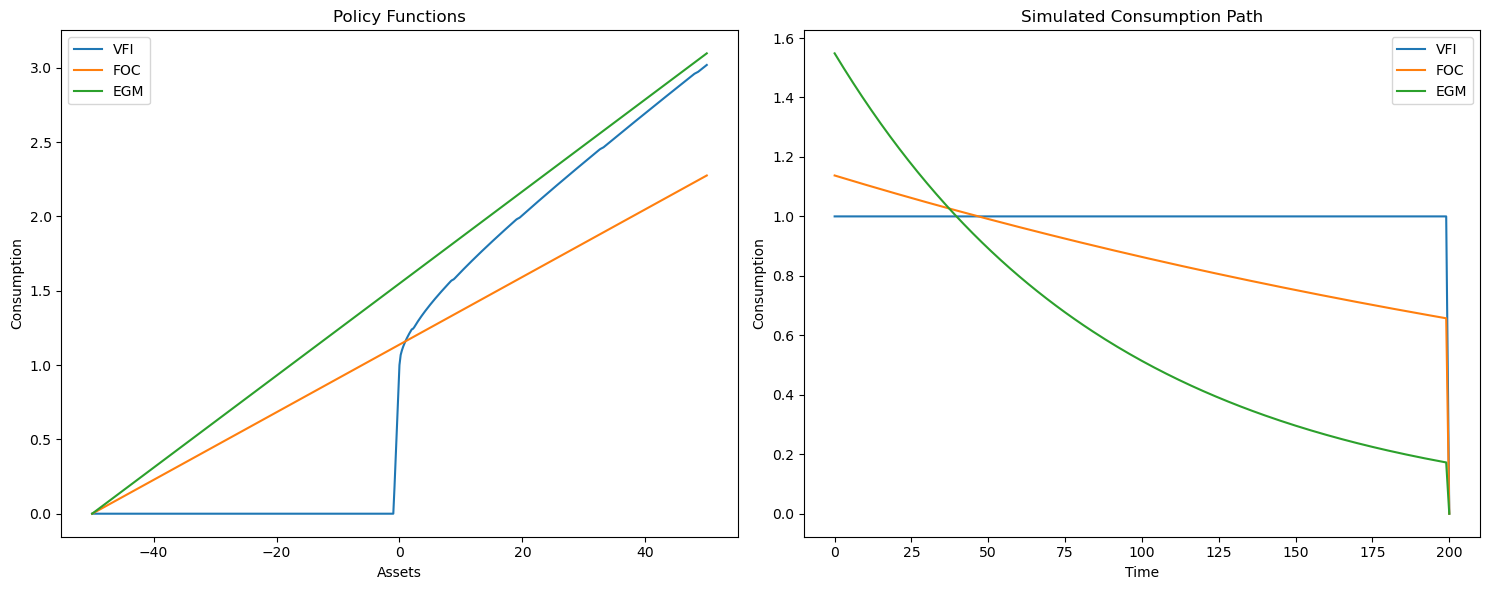

In [23]:
# plots and comparisons

%matplotlib inline
plt.figure(figsize=(15, 6))

# Policy function
plt.subplot(1, 2, 1)
plt.plot(grid_a, policy, label='VFI')
plt.plot(grid_a, c_foc, label='FOC')
plt.plot(grid_a, c_egm, label='EGM')
plt.title("Policy Functions")
plt.xlabel("Assets")
plt.ylabel("Consumption")
plt.legend()

# Simulated paths
plt.subplot(1, 2, 2)
plt.plot(c_vfi, label="VFI")
plt.plot(c_sim_foc, label="FOC")
plt.plot(c_sim_egm, label="EGM")
plt.title("Simulated Consumption Path")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.legend()

plt.tight_layout()
plt.show()